# Bankruptcy Model

In [1]:
# load libaries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import shap

#### Split Data

In [2]:
# load data
data = pd.read_csv('data-final.csv')

In [3]:
# define desired features
y_col = ['DLRSN B','DLRSN L','AA B','FAILURE DLRSN','BNKRPT','FAILURE'][4]
cols = ['NITA','NIMTA','TLTA','TLMTA','CASHMTA','MB','EXRET','RSIZE','PRICE','SIGMA',y_col]
d = data[cols]

# impute missing SIGMA
imp = SimpleImputer()
d['SIGMA'] = imp.fit_transform(d[['SIGMA']])
d['PRICE'] = imp.fit_transform(d[['PRICE']])
d['RSIZE'] = imp.fit_transform(d[['RSIZE']])

# split data into X, y and test, train
d = d.dropna()
X, y = d[cols].drop(columns=y_col), d[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Data Statistics

In [4]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
NITA,1606116.0,-0.007273,0.053103,-0.245683,-0.008595,0.008110,0.018807,0.045693
NIMTA,1606116.0,-0.002847,0.029779,-0.113816,-0.006344,0.006080,0.012504,0.032560
TLTA,1606116.0,0.474169,0.240945,0.059625,0.287220,0.476553,0.635646,1.242966
TLMTA,1606116.0,0.381685,0.243584,0.025577,0.169555,0.357832,0.570216,0.889005
CASHMTA,1606116.0,0.139304,0.165561,0.000839,0.019986,0.067152,0.197493,0.602749
MB,1606116.0,2.995813,3.367355,0.439465,1.030953,1.790164,3.315005,15.095297
EXRET,1606116.0,-0.009512,0.170605,-5.086846,-0.077136,-0.005628,0.062333,5.765262
RSIZE,1606116.0,-3.386754,2.562857,-22.746434,-5.035026,-3.386754,-1.723115,7.435575
PRICE,1606116.0,1.982524,1.032501,-4.556380,1.531476,2.525729,2.708050,2.708050
SIGMA,1606116.0,0.035398,0.028740,0.000000,0.018468,0.028823,0.043209,2.405056


In [5]:
# display target split counts
t = pd.DataFrame()
t['Total'] = d[y_col].value_counts()
t['Train'] = y_train.value_counts()
t['Test'] = y_test.value_counts()
t

,Total,Train,Test
0,1605542,1075721,529821
1,574,376,198


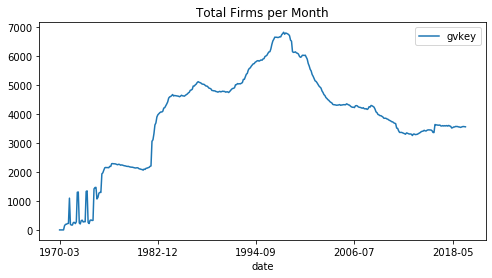

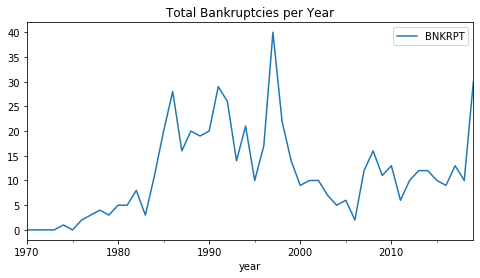

In [7]:
data['year'] = pd.to_datetime(data['date']).dt.to_period('Y')
c = data.groupby(by=['date']).count()
s = data.groupby(by=['year']).sum()
c[['gvkey']].plot(figsize=(8,4), title='Total Firms per Month')
s[['BNKRPT']].plot(figsize=(8,4), title='Total Bankruptcies per Year')

#### Test Models

In [12]:
out = pd.DataFrame()

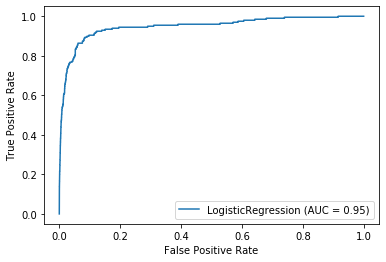

In [13]:
# test logit model
for cw in [None, 'balanced', {0:.09,1:.91}]:
    lgt = LogisticRegression(class_weight=cw, random_state=10, max_iter=10000)
    lgt.fit(X_train, y_train)
    y_pred = lgt.predict(X_test)
    y_prob = pd.DataFrame(lgt.predict_proba(X_test))[0]
    acc = lgt.score(X_test, y_test)
    cr = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prf = precision_recall_fscore_support(y_test, y_pred)
    cols = 'Logit ' + str(cw)
    out[cols] = [acc, auc, prf[0][1], prf[1][1], prf[2][1], prf[3][1], cr]
    print(cols)

plot_roc_curve(lgt, X_test, y_test)

In [14]:
# test Random Forest model
for cw in [None,'balanced']: #range(11,30,2):
    #cw = {0:(1-cw),1:cw}
    rfc = RandomForestClassifier(class_weight=cw, random_state=10)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_prob = pd.DataFrame(rfc.predict_proba(X_test))[0]
    acc = lgt.score(X_test, y_test)
    cr = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prf = precision_recall_fscore_support(y_test, y_pred)
    cols = 'RForest ' + str(cw)
    out[cols] = [acc, auc, prf[0][1], prf[1][1], prf[2][1], prf[3][1], cr]
    print(cols)

RForest None
RForest balanced


In [15]:
out = out.rename(index={0:'accuracy',1:'AUC',2:'percision',3:'recall',4:'fscore',5:'support',6:'report'})
out.T

,accuracy,AUC,percision,recall,fscore,support,report
Logit None,0.999628,0.0529378,1,0.00505051,0.0100503,198,precision recall f1-score ...
Logit balanced,0.903919,0.0484916,0.00356227,0.919192,0.00709704,198,precision recall f1-score ...
"Logit {0: 0.09, 1: 0.91}",0.999523,0.0518704,0.204301,0.0959596,0.130584,198,precision recall f1-score ...
RForest None,0.999523,0.227706,0.944444,0.0858586,0.157407,198,precision recall f1-score ...
RForest balanced,0.999523,0.290125,1,0.0757576,0.140845,198,precision recall f1-score ...


In [ ]:
# !! want to run, takes forever (6+ hours on rfc)
# compute SHAP values and visualize for impact
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)